# Export a Dynamical Decoupling Sequence to Program

Q-CTRL Open Controls provides easy-to-use methods to construct Dynamical Decoupling Sequences (DDS) according to well-known dynamical decoupling schemes. This is described in the [creating a DDS notebook](creating_a_dds.ipynb). Here we show how a DDS from Q-CTRL Open Controls can be exported to a Program defined in Pyquil. We also show how a DDS can decrease the number of errors, when executing a quantum program on a noisy device (simulated by Pyquil).

Note: To create a quantum program, you need to install `pyquil` package. Follow the [instruction](http://docs.rigetti.com/en/stable/start.html) to install `pyquil`. Moreover, in order to simulate the quantum program, you will require the [FOrestSDK](https://www.rigetti.com/forest). Follow the [instruction] (http://docs.rigetti.com/en/stable/start.html) to obtain and install ForestSDK on your computer.

## Imports

In [1]:
#General

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

#Q-CTRL Open Controls
from qctrlopencontrols import new_predefined_dds, convert_dds_to_program

#pyquil
from pyquil.api import get_qc
from pyquil.noise import dephasing_kraus_map

## Running a DDS on a Pyquil Quantum Virtual Machine (QVM)

This section demonstrates how a DDS can be prepared and a corresponding Pyquil program made and executed on a Quantum Virtual Simulator (QVM).

Q-CTRL Open Controls defines a DDS as a set of instantaneous unitary operations performed at specific offset times, see the [technical documentation](https://docs.q-ctrl.com/control-library#dynamical-decoupling-sequences) for mathematical details.

Pyquil implements quantum computation through `Program` that contains a series of [gates](http://docs.rigetti.com/en/stable/apidocs/gates.html). How these gates are physically implemented will depend on the device that it is run on. Rigetti's documentation gives an oversight on Rigetti's [native gates](http://docs.rigetti.com/en/stable/apidocs/gates.html#native-gates-for-rigetti-qpus)] and other [physically realizable gates](http://docs.rigetti.com/en/stable/apidocs/gates.html#all-gates-and-instructions).

If a user wants to add pauses (in time) during a computation they can use identity gates. However, executing a quantum program with identity gates cause the compiler to remove the gates before execution to increase efficiency. This can be avoided by using `Pragma PRESERVE` blocks (see [documentation](http://docs.rigetti.com/en/stable/basics.html#pragmas) for more detail and other usages of `Pragma`).All of $I$ (identity gate), $RX$ (X-rotation gates) and $RY$ (Y-rotation gates) take a fixed time (`gate_time`).

Converting a DDS into a Pyquil program is an approximate process where the instantaneous unitaries are replaced with finite duration gates and the pauses in-between unitaries are replaced with the closest integer number of identity gates. The exact algorithm used to make this approximation is documented in the [source code](XXXX).

In this example we will define a Quadratic DDS and convert it into a program that we can later run on a simulator. See [creating_a_DDS.ipynb](creating_a_DDS.ipynb) to see how other sequences can be created. We also create a Ramsey DDS of the same duration to compare as a benchmark. For both the sequences, we add a $X_{\pi/2}$ rotation on either end of the sequence.

### Preparing the Sequences

In [2]:
## Quadratic sequence, total duration: 20us
quadratic_sequence = new_predefined_dds(
    scheme='quadratic',
    duration=5e-6, 
    number_inner_offsets=2,
    number_outer_offsets=2,
    pre_post_rotation=True,
    name='Quadratic sequence')

# Ramsey sequence, total duration: 20us
ramsey_sequence = new_predefined_dds(
    scheme='Ramsey',
    duration=5e-6,
    pre_post_rotation=True,
    name='Ramsey sequence')

print(quadratic_sequence)
print(ramsey_sequence)

Quadratic sequence:
Duration = 5e-06
Offsets = [0.0,0.06249999999999998,0.18749999999999994,0.24999999999999994,0.37499999999999994,0.6249999999999999,0.7499999999999999,0.8124999999999999,0.9375,1.0] x 5e-06
Rabi Rotations = [0.5,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.5] x pi
Azimuthal Angles = [0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0] x pi
Detuning Rotations = [0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0] x pi
Ramsey sequence:
Duration = 5e-06
Offsets = [0.0,1.0] x 5e-06
Rabi Rotations = [0.5,0.5] x pi
Azimuthal Angles = [0.0,0.0] x pi
Detuning Rotations = [0.0,0.0] x pi


### Constructing the Program Using Q-CTRL Open Controls

To construct a `Program` from a DDS, we need to provide the DDS (`dynamic_decoupling_sequence`). You can also provide a list (`target_qubits`) to indicate qubit indices on which the DDS will be applied. `gate_time` is the delay (in seconds) introduced by each of the `identity` gates. If measurement is required, use `add_measurement=True`.

In this example, we will use $0$th qubit and specify the `gate_time` to be $50$ $n$s (see [noise specification](http://docs.rigetti.com/en/stable/apidocs/autogen/pyquil.noise.add_decoherence_noise.html#pyquil.noise.add_decoherence_noise)). Both the DDS will require a measurement operation.

In [3]:
## Prepare the Pyquil related parameters
'''
target_qubits : list
    A list of integers specifying the target qubits within the set of qubit registers
'''
target_qubits = [0]

'''
gate_time : float
    Time delay (in seconds) introduced by identity gate
'''
gate_time = 50e-9

'''
add_measurement : bool
    Indicates if the program requires a measurement step.
'''
add_measurement = True

## convert the quadratic sequence to program
quadratic_program = convert_dds_to_program(
    dynamic_decoupling_sequence=quadratic_sequence,
    target_qubits=target_qubits,
    gate_time=gate_time,
    add_measurement=add_measurement,
)

## convert the ramsey sequence to program
ramsey_program = convert_dds_to_program(
    dynamic_decoupling_sequence=ramsey_sequence,
    target_qubits=target_qubits,
    gate_time=gate_time,
    add_measurement=add_measurement
)

### Plotting the DDS

We can use Q-CTRL Open Controls to plot the DDS for comparison against their Pyquil program approximations.

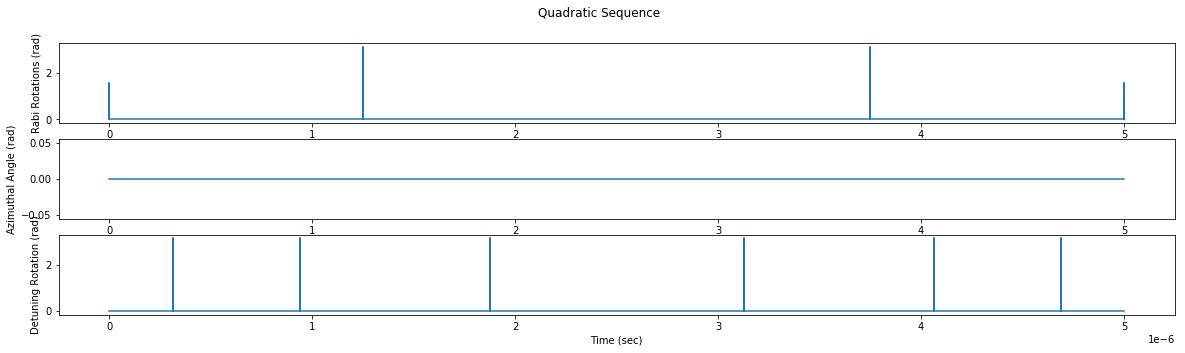

In [4]:
formatted_plot_data = quadratic_sequence.get_plot_formatted_arrays()
rabi_rotations, azimuthal_angles, detuning_rotations, times = (
    formatted_plot_data['rabi_rotations'],
    formatted_plot_data['azimuthal_angles'],
    formatted_plot_data['detuning_rotations'],
    formatted_plot_data['times']
)

# prepare the axes
figure, (rabi_plot_axis, azimuth_plot_axis, detuning_plot_axis) = plt.subplots(
    3, 1, figsize=(20,5))

rabi_plot_axis.plot(times, rabi_rotations)
rabi_plot_axis.ticklabel_format(style='sci', axis='x', scilimits=(0, 2))
rabi_plot_axis.set_xlabel('Time (sec)')
rabi_plot_axis.set_ylabel('Rabi Rotations (rad)')

azimuth_plot_axis.plot(times, azimuthal_angles)
azimuth_plot_axis.ticklabel_format(style='sci', axis='x', scilimits=(0, 2))
azimuth_plot_axis.set_xlabel('Time (sec)')
azimuth_plot_axis.set_ylabel('Azimuthal Angle (rad)')

detuning_plot_axis.plot(times, detuning_rotations)
detuning_plot_axis.ticklabel_format(style='sci', axis='x', scilimits=(0, 2))
detuning_plot_axis.set_xlabel('Time (sec)')
detuning_plot_axis.set_ylabel('Detuning Rotation (rad)')

plt.suptitle('Quadratic Sequence')
plt.show()

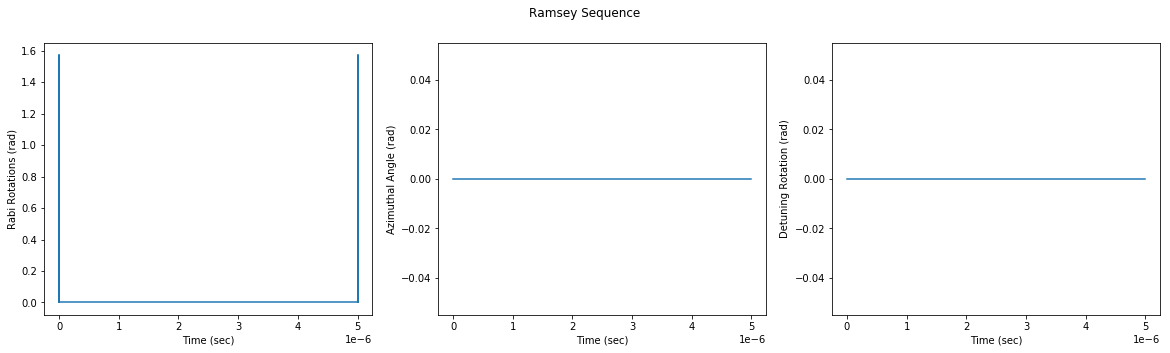

In [5]:
formatted_plot_data = ramsey_sequence.get_plot_formatted_arrays()
rabi_rotations, azimuthal_angles, detuning_rotations, times = (
    formatted_plot_data['rabi_rotations'],
    formatted_plot_data['azimuthal_angles'],
    formatted_plot_data['detuning_rotations'],
    formatted_plot_data['times']
)

# prepare the axes
figure, (rabi_plot_axis, azimuth_plot_axis, detuning_plot_axis) = plt.subplots(
    1, 3, figsize=(20,5))

rabi_plot_axis.plot(times, rabi_rotations)
rabi_plot_axis.ticklabel_format(style='sci', axis='x', scilimits=(0, 2))
rabi_plot_axis.set_xlabel('Time (sec)')
rabi_plot_axis.set_ylabel('Rabi Rotations (rad)')

azimuth_plot_axis.plot(times, azimuthal_angles)
azimuth_plot_axis.ticklabel_format(style='sci', axis='x', scilimits=(0, 2))
azimuth_plot_axis.set_xlabel('Time (sec)')
azimuth_plot_axis.set_ylabel('Azimuthal Angle (rad)')

detuning_plot_axis.plot(times, detuning_rotations)
detuning_plot_axis.ticklabel_format(style='sci', axis='x', scilimits=(0, 2))
detuning_plot_axis.set_xlabel('Time (sec)')
detuning_plot_axis.set_ylabel('Detuning Rotation (rad)')

plt.suptitle('Ramsey Sequence')
plt.show()

### Compiling and running the pograms

We can use `pyQuil` to compile the programs generated by Q-CTRL Open Controls. In order to achieve that, we need to create a suitable QVM;1-qubit device in this case.

NOTE: You will require ForestSDK to run the following segments. You need to start the the Quil Compiler and QVM in server mode. Execute the following commands in separate prompts.

```
$ quilc -S
$ qvm -S
```

In [6]:
# NBVAL_SKIP

# create a noiseless quantum device with 1-qubit
quantum_device = get_qc("1q-qvm")

#### Compiling the Quadratic DDS Program

Note that both DDS will be applied with $X_{\pi/2}$ rotations at beginning and end, that is, at offsets of $[0, 20]$ $\mu$s, to create the desired superposition state. The $X_{\pi/2}$ rotations are added to the programs in the form of pre-post-gates that are implemented via Pyquil's $RX(\pi/2)$ gate.

The $RZ(\pi)$ gates are $Z_\pi$ pulses (a $\pi$ rotation around $Z$-axis) and $RX(\pi)$ correspond to $X_{\pi}$ pulses (a $\pi$ rotation around $X$-axis). The gates match the pulses in the DDS.

The `I()` in the compiled program corresponds to the `identity` gates. In the DDS, the first $Z_{\pi}$-pulse is applied at a delay of $0.3125$ $\mu$s. This is approximated by introducing 6-`Id` gates with a delay of $50ns\times 6=0.3$ $\mu s$. Similarly, the second set of 12-`Id` gates introduces a delay of $0.6$ $\mu s$ close to the actual delay of $0.9375-0.3125=0.625\mu s$.

The `Pragma` preserve blocks are added at the start and end of the program so that the compiler preserves the entire program. Without the preserve blocks the intermediate identity gates could be removed by compiler and hence the DDS would not have achieved the gaps required between the rotation operations.

At the end of each program, we place a `measurement` operator to read out the result.

In [7]:
# NBVAL_SKIP

##Compiling the quadratic program
executable_quadratic_program = quantum_device.compile(quadratic_program)
## print the compiled program
print(executable_quadratic_program.program)

DECLARE qubit-0 BIT[1]
RX(pi/2) 0
I 0
I 0
I 0
I 0
I 0
I 0
RZ(pi) 0
I 0
I 0
I 0
I 0
I 0
I 0
I 0
I 0
I 0
I 0
I 0
I 0
RZ(pi) 0
I 0
I 0
I 0
I 0
I 0
I 0
RX(pi) 0
I 0
I 0
I 0
I 0
I 0
I 0
I 0
I 0
I 0
I 0
I 0
I 0
RZ(pi) 0
I 0
I 0
I 0
I 0
I 0
I 0
I 0
I 0
I 0
I 0
I 0
I 0
I 0
I 0
I 0
I 0
I 0
I 0
I 0
I 0
I 0
I 0
I 0
I 0
I 0
RZ(pi) 0
I 0
I 0
I 0
I 0
I 0
I 0
I 0
I 0
I 0
I 0
I 0
I 0
RX(pi) 0
I 0
I 0
I 0
I 0
I 0
I 0
RZ(pi) 0
I 0
I 0
I 0
I 0
I 0
I 0
I 0
I 0
I 0
I 0
I 0
I 0
RZ(pi) 0
I 0
I 0
I 0
I 0
I 0
I 0
RX(pi/2) 0
MEASURE 0 qubit-0[0]
HALT



#### Compiling the Ramsey program

Compiling the program for Ramsey sequence is similar.

In [8]:
# NBVAL_SKIP


##Compiling the quadratic program
executable_ramsey_program = quantum_device.compile(ramsey_program)
## print the compiled program
print(executable_ramsey_program.program)

DECLARE qubit-0 BIT[1]
RX(pi/2) 0
I 0
I 0
I 0
I 0
I 0
I 0
I 0
I 0
I 0
I 0
I 0
I 0
I 0
I 0
I 0
I 0
I 0
I 0
I 0
I 0
I 0
I 0
I 0
I 0
I 0
I 0
I 0
I 0
I 0
I 0
I 0
I 0
I 0
I 0
I 0
I 0
I 0
I 0
I 0
I 0
I 0
I 0
I 0
I 0
I 0
I 0
I 0
I 0
I 0
I 0
I 0
I 0
I 0
I 0
I 0
I 0
I 0
I 0
I 0
I 0
I 0
I 0
I 0
I 0
I 0
I 0
I 0
I 0
I 0
I 0
I 0
I 0
I 0
I 0
I 0
I 0
I 0
I 0
I 0
I 0
I 0
I 0
I 0
I 0
I 0
I 0
I 0
I 0
I 0
I 0
I 0
I 0
I 0
I 0
I 0
I 0
I 0
I 0
I 0
I 0
RX(pi/2) 0
MEASURE 0 qubit-0[0]
HALT



And here we count 100 `Id` operations, implementing a total delay of $100 \times 50 ns = 5 \mu s$

### Run the programs using Pyquil's QVM

Here, we will use the quantum device we created earlier to run the program. The experiment consists of `trials` repeats of the program on a qubit. Each run collects the state of the qubit as measurement. The result is displayed as a histogram. We here define small utility method to plot the trial results for QVM.

In [9]:
def plot_trial_outcomes(trial_result, qubit = 0):
    """Plots the trial result as probabilities.
    Parameters
    ----------
    trial_result : dict
        A dict where the key is the target qubits and value is a numy array of size
        containing outcome of each trial in computational basis.
    qubit: int
        An interger corresponding to the target qubit.
    """
    
    qubit_trial_result = trial_result[qubit]
    
    number_of_trials = qubit_trial_result.shape[0]
    
    outcome = np.array([number_of_trials-np.sum(qubit_trial_result), np.sum(qubit_trial_result)])
    outcome_probabilities = outcome / number_of_trials
    
    ##plotting the outcome probabilities
    #ax = plt.subplots(1,1)
    #ax.bar([0, 1], outcome_probabilities)
    #ax.xlabel('States')
    #ax.xticks(ticks=[0, 1])
    #ax.ylabel('Probabilities')
    plt.bar(np.array([0, 1]), outcome_probabilities)
    plt.xticks(np.array([0, 1]), [0, 1])
    plt.ylabel('Probabilities')
    plt.xlabel('States')
    
'''
trials : int
    An integer denoting the number of repeats of the program on quantum device
'''
trials=100

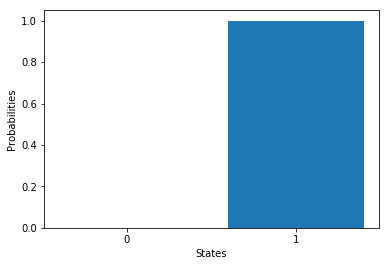

In [10]:
# NBVAL_SKIP

## Run the quadratic sequence program, Get the result (counts of state |1> and |0>), plot the histogram
quadratic_result = quantum_device.run_and_measure(quadratic_program, trials=trials)
plot_trial_outcomes(quadratic_result)

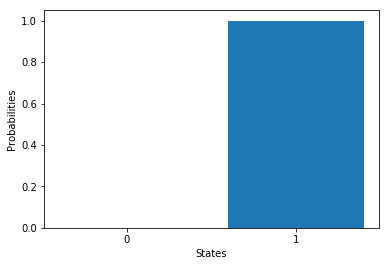

In [11]:
# NBVAL_SKIP

## Run the ramsey sequence program, Get the result (counts of state |1> and |0>), plot the histogram
ramsey_result = quantum_device.run_and_measure(ramsey_program, trials=trials)
plot_trial_outcomes(ramsey_result)

### Run the programs with noise

We use the same DDS and program defined above. However, in this case, we define a dephasing noise for the identity gates through appropriate Kraus Operator with specific dephasing probability. We introduce the noise to the programs. We then run the programs with noisy gates on the same device created above. Outcome of these experiments are plotted and compared with that obtained from ideal gates.

In [12]:
# define a one-shot dephasing probability
p = 0.02

# define a dephasing with probability p
kraus_operators = dephasing_kraus_map(p=p)

#### Running the quadratic sequence program with noisy identity gates

Here we will introduce the noisy identity gates to the quadratic sequence program, run it on the virtual device and plot the outcome.

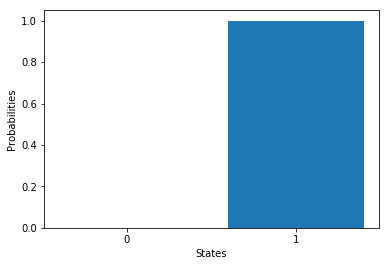

In [13]:
# NBVAL_SKIP

#add noise to the identity gates
noisy_quadratic_program = quadratic_program.define_noisy_gate("I", [1], kraus_operators)
#obtain the noisy result
noisy_quadratic_result = quantum_device.run_and_measure(noisy_quadratic_program, trials=trials)
#plot the noisy results
plot_trial_outcomes(noisy_quadratic_result)

#### Running the ramsey sequence program with noisy identity gates

Here we will introduce the noisy identity gates to the ramsey sequence program, run it on the virtual device and plot the outcome.

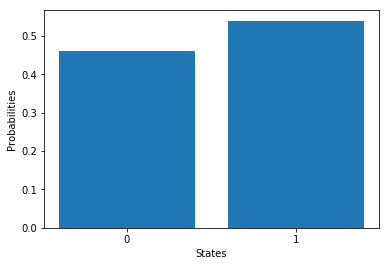

In [14]:
# NBVAL_SKIP

#add noise to the identity gates
noisy_ramsey_program = ramsey_program.define_noisy_gate("I", target_qubits, kraus_operators)
#obtain the noisy result
noisy_ramsey_result = quantum_device.run_and_measure(noisy_ramsey_program, trials=trials)
#plot the noisy results
plot_trial_outcomes(noisy_ramsey_result)

## Reducing Errors by Increasing the Coherence Time

In the ideal noiseless simulator, both the Ramsey DDS and Quadratic DDS produced exactly the same outcome, the $|1 \rangle$ state with probability 1. However, in the case of noisy channels, we can see a marked difference. The Quadratic DDS produced a probability distribution closer to the expected outcome. This is because the Quadratic DDS is able to cancel the effects of magnetic noise in the environment - extending the [T2 time](https://en.wikipedia.org/wiki/Spin–spin_relaxation), and effectively increasing the coherence of the qubit.